# Heatwave hazard assessment based on EURO-CORDEX data analysis

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [HEATWAVES](https://github.com/CLIMAAX/HEATWAVES) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

## Description of the assessment

In this workflow we will assess the heatwave hazard by directly analyzing EURO-CORDEX climate model data, making use of the [xclim package](https://xclim.readthedocs.io/en/stable/indices.html) to compute heatwave indicators.  

Xclim package allows to identify hot and cold spells in the data, calculate heatwave frequency (per year) and total length of heatwaves.

In this workflow the heatwave definition is based on user-defined absolute temperature thresholds for the maximum and minimum daily temperatures (i.e. day and night temperatures), and a mimimum time duration (e.g. 2 or 3 days). Using absolute thresholds for temperature requires input from the user, these limits can be made specific to the region of interest and based on expected health impacts.

The calculation is based on climate data with resolution of 12x12km (EURO-CORDEX), where data is available for 1971-2100.

**Advantages of using this methodology:**
- Heatwave calculation based on the minimum and maximum temperature, suitable also for the regions where the temperature can significantly cool down at night.
- Flexibility of the methodology: the possibility of changing the temperature thresholds according to the needs of the user.

**Disadvantages:**
- Computationally intensive due to the large amount of data.
- Heatwaves are estimated on a yearly basis - not possible to analyze seasonal heatwaves.

## Step 1: Preparation work

### Import packages

:::{admonition} In this notebook we will use the following Python libraries:
:class: hint dropdown
* [zipfile](https://docs.python.org/3/library/zipfile.html) - Working with ZIP archive files (compression and extraction).
* [os](https://docs.python.org/3/library/os.html) - Interacting with the operating system, including handling the current working directory.
* [rasterio](https://rasterio.readthedocs.io/en/latest/) - Reading and writing geospatial raster data.
* [cdsapi](https://cds.climate.copernicus.eu/how-to-api) - Interacting with the Climate Data Store (CDS) API for downloading climate data.
* [numpy](https://numpy.org/doc/stable/) - Handling large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
* [xarray](https://docs.xarray.dev/en/stable/) - Handling labeled multi-dimensional arrays, commonly used for 2D and 3D array data handling.
* [dask](https://docs.dask.org/en/stable/index.html) - Efficient handling of large datasets and computations.
* [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - Cartographic projections and coordinate transformations for geospatial data.
* [plotly](https://plotly.com/) - Creating interactive plots and visualizations.
* [ipyleaflet](https://ipyleaflet.readthedocs.io/en/stable/) - Creating interactive maps in Jupyter notebooks.
* [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) - Creating interactive HTML widgets for Jupyter notebooks.
* [localtileserver](https://localtileserver.readthedocs.io/en/latest/) - Serving local raster data as tiles and integrating with Leaflet maps.
* [xclim](https://xclim.readthedocs.io/en/stable/) - Climate indices computation and analysis based on netCDF files using xarray.

In [1]:
import zipfile
import os
from itertools import chain

import rasterio
import cdsapi
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
import plotly.graph_objects as go
from ipyleaflet import Map, DrawControl, Marker, LayersControl
import ipywidgets as widgets
from localtileserver import get_leaflet_tile_layer, TileClient
import xclim
from IPython.display import display

In [2]:
# Set host forwarding for remote jupyterlab sessions
if 'JUPYTERHUB_SERVICE_PREFIX' in os.environ:
    os.environ['LOCALTILESERVER_CLIENT_PREFIX'] = f"{os.environ['JUPYTERHUB_SERVICE_PREFIX']}/proxy/{{port}}"

### Create directory structure

In [3]:
# Define the directory for the heatwave workflow preprocess
workflow_folder = 'Heatwave_hazard_XCLIM'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_folder,'data')
results_dir = os.path.join(workflow_folder,'results')

# Create the workflow directory along with subdirectories for data and results
os.makedirs(workflow_folder, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

## Step 2: Retrieving data

### Download climate data from the CDS

You can download data from the CDS with the API - look at [[How to change your API KEY](https://cds.climate.copernicus.eu/how-to-api)] and change the KEY below for authentication.


In [ ]:
URL = "https://cds.climate.copernicus.eu/api"
KEY = None # put your key here

c = cdsapi.Client(url=URL, key=KEY)

We need to download the daily maximum and daily minimum air temperature at 2m height from the EURO-CORDEX dataset. The code below will download this data for the selected period and RCP scenario.
- In the code below you can find information about selected locations, resolutions, models, periods, etc.
- More information about the **data** you can find [here](https://cds.climate.copernicus.eu/datasets/projections-cordex-domains-single-levels?tab=overview)
- More information about **RCP** scenarios can be found [here](https://en.wikipedia.org/wiki/Representative_Concentration_Pathway)

:::{important}

We will only download data for a single combination of GCM and RCM models. Below you can specify which combination you would like to use.
For a more reliable result of the assessment, it is recommended to make the analysis for several combinations of GCM-RCM.
For an overview of available combinations see the [CDS download form](https://cds.climate.copernicus.eu/datasets/projections-cordex-domains-single-levels?tab=download) and [documentation on GCM-RCM models](https://confluence.ecmwf.int/display/CKB/CORDEX%3A+Regional+climate+projections#heading-DrivingGlobalClimateModelsandRegionalClimateModels).
:::

In [4]:
gcm_model = 'mpi_m_mpi_esm_lr'  # 'cnrm_cerfacs_cm5' 'mohc_hadgem2_es'
rcm_model = 'clmcom_clm_cclm4_8_17'

cordex_default_request_parameters = {
    'format': 'zip',
    'domain': 'europe',
    'gcm_model': gcm_model,
    'rcm_model': rcm_model,
    'ensemble_member': 'r1i1p1',
    'horizontal_resolution': '0_11_degree_x_0_11_degree',
    'temporal_resolution': 'daily_mean',
}

First we download the daily maximum 2m temperature for 1971-2005.

In [ ]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'eurocordex_daily_t2m_eurmax_1971_2005.zip')

# Download the data for the selected time-period and RCP
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        **cordex_default_request_parameters,
        'experiment': 'historical',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'start_year': [
            '1971', '1976', '1981', '1986', '1991', '1996', '2001', 
        ],
        'end_year': [
            '1975', '1980', '1985', '1990', '1995', '2000', '2005',
        ],
    },
    zip_path
)

# Unzip the downloaded files so they are ready for computing 
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

# Remove the downloaded zip file after unpacking
os.remove(zip_path)

Now we can download the daily minimum 2m temperature for 1971-2005.

In [ ]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'eurocordex_daily_t2m_eurmin_1971_2005.zip')

# Download the data for the selected time-period and RCP
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        **cordex_default_request_parameters,
        'experiment': 'historical',
        'variable': 'minimum_2m_temperature_in_the_last_24_hours',
        'start_year': [
            '1971', '1976', '1981', '1986', '1991', '1996','2001',
        ],
        'end_year': [
            '1975', '1980', '1985', '1990', '1995', '2000','2005',
        ],
    },
    zip_path
)

# Unzip the downloaded files so they are ready for computing 
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

# Remove the downloaded zip file after unpacking
os.remove(zip_path)

Next we download the daily **maximum** temperature at 2m for **RCP8.5**.

You can select the period for download: 2006-2100 by default but you can select other shorter period (e.g. 2041-2070, 2071-2100) to limit the amount of data.

In [ ]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'eurocordex_daily_t2m_eurminmax_2006_2100.zip')

# Download the data for the selected time-period and RCP
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        **cordex_default_request_parameters,
        'experiment': 'rcp_8_5',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'start_year': [
            '2006','2011', '2016', '2021', '2026', '2031', '2036', '2041', '2046',
            #'2051', '2056', '2061', '2066', '2071', '2076', '2081', '2086', '2091', '2096'
        ],
        'end_year': [
            '2010','2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050',
            #'2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100'
        ],
    },
    zip_path
)

# Unzip the downloaded files so they are ready for computing 
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

# Remove the downloaded zip file after unpacking
os.remove(zip_path)

Next we download the daily **minimum** temperature at 2m for **RCP8.5**.

You can select the period for download: 2006-2100 by default but you can select other shorter period (e.g. 2041-2070, 2071-2100) to limit the amount of data.

In [ ]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'eurocordex_daily_t2m_eurmin_2006_2100.zip')

# Download the data for the selected time-period and RCP
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        **cordex_default_request_parameters,
        'experiment': 'rcp_8_5',
        'variable': 'minimum_2m_temperature_in_the_last_24_hours',
        'start_year': [
            '2006','2011', '2016', '2021', '2026', '2031', '2036', '2041', '2046',
            #'2051', '2056', '2061', '2066', '2071', '2076', '2081', '2086', '2091', '2096'
        ],
        'end_year': [
            '2010','2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050',
            #'2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100'
        ],
    },
    zip_path
)

# Unzip the downloaded files so they are ready for computing 
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

# Remove the downloaded zip file after unpacking
os.remove(zip_path)

Next we download the daily **maximum** temperature at 2m for **RCP4.5**.

You can select the period for download: 2006-2100 by default but you can select other shorter period (e.g. 2041-2070, 2071-2100) to limit the amount of data.

In [ ]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'eurocordex_daily_t2m_eurmax_rcp45_2006_2100.zip')

# Download the data for the selected time-period and RCP
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        **cordex_default_request_parameters,
        'experiment': 'rcp_4_5',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'start_year': [
            '2006','2011', '2016', '2021', '2026', '2031', '2036', '2041', '2046',
            #'2051', '2056', '2061', '2066', '2071', '2076', '2081', '2086', '2091', '2096'
        ],
        'end_year': [
            '2010','2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050',
            #'2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100'
        ],
    },
    zip_path
)

# Unzip the downloaded files so they are ready for computing 
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

# Remove the downloaded zip file after unpacking
os.remove(zip_path)

Next we download the daily **minimum** temperature at 2m for **RCP4.5**. 

You can select the period for download: 2006-2100 by default but you can select other shorter period (e.g. 2041-2070, 2071-2100) to limit the amount of data.

In [ ]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'eurocordex_daily_t2m_eurmin_rcp45_2006_2100.zip')

# Download the data for the selected time-period and RCP
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        **cordex_default_request_parameters,
        'experiment': 'rcp_4_5',
        'variable': 'minimum_2m_temperature_in_the_last_24_hours',
        'start_year': [
            '2006','2011', '2016', '2021', '2026', '2031', '2036', '2041', '2046',
            #'2051', '2056', '2061', '2066', '2071', '2076', '2081', '2086', '2091', '2096'
        ],
        'end_year': [
            '2010','2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050',
            #'2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100'
        ],
    },
    zip_path
)

# Unzip the downloaded files so they are ready for computing 
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

# Remove the downloaded zip file after unpacking
os.remove(zip_path)

In [ ]:
# rename all files to lowercase to enable easier subsetting of files per model
for file in os.listdir(data_dir):
    os.rename(os.path.join(data_dir,file),os.path.join(data_dir,file.lower()))

### Load data

Load data from your working directory, and set the coordinates system (CRS).  

In the code below we will load the data that was downloaded in the previous step, filtering the filenames to select only the data for the specific GCM that was selected (needed in case several models were already downloaded to the same folder, and assuming the RCM stays the same). 

In [5]:
# EURO-CORDEX rotated coordinate reference system
CORDEX_CRS = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)

def open_euro_cordex_files(pattern, **kwargs):
    """Dataset from EURO-CORDEX files with CRS set"""
    return xr.open_mfdataset(
        pattern,
        decode_coords="all",
        chunks={"time": 64},
        **kwargs
    ).rio.write_crs(CORDEX_CRS)

gcm_model_aspath = gcm_model.replace("_", "-")

# Historical maximum and minimum temperature
dsh = open_euro_cordex_files(f'{data_dir}/tas*{gcm_model_aspath}*historical*.nc')

# Maximum and minimum temperature RCP4.5
ds45 = open_euro_cordex_files(f'{data_dir}/tas*{gcm_model_aspath}*rcp45*.nc')

# Maximum and minimum temperature RCP8.5
ds85 = open_euro_cordex_files(f'{data_dir}/tas*{gcm_model_aspath}*rcp85*.nc')

print("Data loaded and crs has been set!")

Data loaded and crs has been set!


### Selection of the region of interest

**Tip for the selection of the area:**
Select at least the area of the region or state where you want to compute (bigger area is better for graphical comparison, for EURO-CORDEX resolution of 12x12km)
- "Zoom" to your area with [+] (top left corner)
- "Click" on the rectangle on the left panel
- "Select your area" by left click and drag
-  And run a code below which "automatically" takes the coordinates of your area and transforms it to rotated pole CRS which is used by the EuroCordex data

In [6]:
# This code plots a map where you need to select a bounding box, as an area for the heatwave estimation
# Create a map centered at a specific location
m = Map(center=(55, 20), zoom=3)
# Create lists to store rectangle coordinates
min_lon_list = []
min_lat_list = []
max_lon_list = []
max_lat_list = []
# Create a DrawControl with rectangle drawing enabled
draw_control = DrawControl(rectangle={'shapeOptions': {'color': '#ff0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)
# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)

# Define a function to handle draw events
def handle_draw_polygon(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Polygon':
            # Extract coordinates of the rectangle
            coords = geo_json['geometry']['coordinates'][0]
            # Compute rectangle coordinates (min_lon, min_lat, max_lon, max_lat)
            min_lon, min_lat = min(coord[0] for coord in coords), min(coord[1] for coord in coords)
            max_lon, max_lat = max(coord[0] for coord in coords), max(coord[1] for coord in coords)
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({min_lon:.2f}, {min_lat:.2f}), ({max_lon:.2f}, {max_lat:.2f})'
            # Append coordinates to lists
            min_lon_list.append(min_lon)
            min_lat_list.append(min_lat)
            max_lon_list.append(max_lon)
            max_lat_list.append(max_lat)

# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw_polygon)
# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

:::{note}
The coordinates will be automatically taken to next steps, you do not need to copy them!
:::

Extract the coordinates from the bounding box selected above and transform it to rotated pole coordinates:

In [7]:
a = min_lon_list + min_lat_list
b = max_lon_list + max_lat_list

source_crs = ccrs.PlateCarree()  # WGS84 CRS

# Example coordinates in WGS 84
wgs84_coords = [a, b]

# Perform the transformation for each pair of coordinates
rotated_pole_coords = []
for lon, lat in wgs84_coords:
    rotated_pole_coords.append(CORDEX_CRS.transform_point(lon, lat, source_crs))

print("WGS 84 Coordinates:", wgs84_coords)
print("Rotated Pole Coordinates:", rotated_pole_coords)

WGS 84 Coordinates: [[17.774759, 48.755623], [19.609662, 49.631506]]
Rotated Pole Coordinates: [(-0.14858485975351823, -1.9941508322387536), (1.0426948253977242, -1.1071515746911893)]


Create a list from the coordinates in WGS84:

In [8]:
# Convert the list of tuples to a single tuple
bbox84 = tuple(chain.from_iterable(wgs84_coords))
print(bbox84)

(17.774759, 48.755623, 19.609662, 49.631506)


Bounding box for clipping:

In [9]:
bbox = {
    "minx": rotated_pole_coords[0][0],
    "maxx": rotated_pole_coords[1][0],
    "miny": rotated_pole_coords[0][1],
    "maxy": rotated_pole_coords[1][1]
}

### Clip data to the region and time periods of interest

Crop the loaded data to the selected bounding box (selected area):

In [33]:
# Historical
dsh_clip = dsh.sel({"time": slice("1971-01-01", "2005-12-31")}).rio.clip_box(**bbox)

# Climate projections
ds45_clip = ds45.sel({"time": slice("2006-01-01", "2100-12-31")}).rio.clip_box(**bbox)
ds85_clip = ds85.sel({"time": slice("2006-01-01", "2100-12-31")}).rio.clip_box(**bbox)

If the size of the area is relatively small (city-scale) we can load the data into memory for faster calculation:

In [11]:
with ProgressBar():
    dsh_clip.load()
    ds45_clip.load()
    ds85_clip.load();

## Step 3: Calculation of the heatwave occurrence based on the XCLIM methodology

Convert the maximum temperature data from Kelvin (K) to Celsius (°C)

In [12]:
def to_celcius(da):
    """Convert Kelvin to degrees Celcius and retain metadata"""
    da = (da - 273.15).assign_attrs(dsh_clip['tasmax'].attrs)
    da.attrs['units'] = "°C"
    return da

# Max and min temperature historical
tasmaxh = to_celcius(dsh_clip['tasmax'])
tasminh = to_celcius(dsh_clip['tasmin'])

# Max and min temperature rcp 45
tasmaxp_45 = to_celcius(ds45_clip['tasmax'])
tasminp_45 = to_celcius(ds45_clip['tasmin'])

# Max and min temperature rcp 85
tasmaxp_85 = to_celcius(ds85_clip['tasmax'])
tasminp_85 = to_celcius(ds85_clip['tasmin'])

XCLIM is an operational Python library for climate services, providing numerous climate-related indicator tools with a framework for constructing custom climate indicators, statistical downscaling and bias adjustment of climate model simulations, as well as climate model ensemble analysis tools.
XCLIM is built using xarray and can seamlessly benefit from the parallelization handling provided by dask. Its objective is to make it as simple as possible for users to perform typical climate data analyses. Leveraging xarray and dask, users can easily bias-adjust climate simulations over large spatial domains or compute indices from large climate datast [[XCLIM](https://xclim.readthedocs.io/en/stable/indicators.html)]


Examples of the code for the computing of the climate indices.

```python
xclim.indices.heat_wave_max_length(tasmin, tasmax, thresh_tasmin='22.0 degC', thresh_tasmax='30 degC', window=3, freq='YS', op='>', resample_before_rl=True)
```
  
In the example above (from XCLIM documentation) the thresholds of 22°C for night temperatures and 30°C for day temperatures were selected by Health Canada professionals, following a temperature–mortality analysis. These absolute temperature thresholds characterize the occurrence of hot weather events that can result in adverse health outcomes for Canadian communities [Casati et al., 2013]. For other regions these thresholds may need to be selected differently.

### Defining the temperature and duration tresholds

Threshold temperatures based on the impact on human health:

1. Based on the preferred studies e.g.: A multi-city epidemiologic study in Europe found that the mortality threshold for heat effects was 29.4 °C for Mediterranean cities and 23.3 °C for the north European cities [[Maximum temperature threshold for EU](https://pubmed.ncbi.nlm.nih.gov/18520615/)].
2. Or use the thresholds for minimum and maximum temperature given by your national meteorological or health service.

We select three climate indices from the Xclim package:

1. Heatwave index
2. Heatwave frequency
3. Heatwave total length

But you can also choose others, all climate indices are listed on the [Xclim website](https://xclim.readthedocs.io/en/stable/indices.html#).

:::{tip}

Customize the heatwave indices with the temperature and duration thresholds for heatwave detection.
The detection criteria may vary between indices.
:::

#### Calculating the heatwave index [[source](https://xclim.readthedocs.io/en/stable/indices.html#xclim.indices.heat_wave_index)]

We need to specify:

- Temperature threshold for maximum daily air temperature (in degC)
- Duration threshold (in days)

In [13]:
index_settings = {
    'thresh': '25.0 degC',  # maximum daily temperature threshold
    'window': 5,  # duration threshold in days
    'freq': 'YS',
    'op': '>',
    'resample_before_rl': True
}

HWIh = xclim.indices.heat_wave_index(tasmaxh, **index_settings)
HWIp45 = xclim.indices.heat_wave_index(tasmaxp_45, **index_settings)
HWIp85 = xclim.indices.heat_wave_index(tasmaxp_85, **index_settings)

#### Calculating the heatwave frequency [[source](https://xclim.readthedocs.io/en/stable/indices.html#xclim.indices.heat_wave_frequency)]

We need to specify:

- Temperature threshold for minimum daily air temperature (in degC) 
- Temperature threshold for maximum daily air temperature (in degC) 
- Duration threshold (in days)

In [14]:
frequency_settings = {
    'thresh_tasmin': '22.0 degC',  # minimum daily temperature threshold
    'thresh_tasmax': '28.0 degC',  # maximum daily temperature threshold
    'window': 3,  # duration threshold in days
    'freq': 'YS',
    'op': '>',
    'resample_before_rl': True
}

HWFh = xclim.indices.heat_wave_frequency(tasminh, tasmaxh, **frequency_settings).astype(np.float64)
HWFp45 = xclim.indices.heat_wave_frequency(tasminp_45, tasmaxp_45, **frequency_settings).astype(np.float64)
HWFp85 = xclim.indices.heat_wave_frequency(tasminp_85, tasmaxp_85, **frequency_settings).astype(np.float64)

#### Calculating heatwave total length [[source](https://xclim.readthedocs.io/en/stable/indices.html#xclim.indices.heat_wave_total_length)]

We need to specify:

- Temperature threshold for minimum daily air temperature (in degC) 
- Temperature threshold for maximum daily air temperature (in degC) 
- Duration threshold (in days)

We can, e.g., use the same thresholds as for the heatwave frequency indicator (above).

In [15]:
total_length_settings = {
    'thresh_tasmin': '22.0 degC',  # tminimum daily temperature threshold
    'thresh_tasmax': '28.0 degC',  # maximum daily temperature threshold
    'window': 3,  # duration threshold in days
    'freq': 'YS',
    'op': '>',
    'resample_before_rl': True
}

HWTLh = xclim.indices.heat_wave_total_length(tasminh, tasmaxh, **total_length_settings)
HWTLp45 = xclim.indices.heat_wave_total_length(tasminp_45, tasmaxp_45, **total_length_settings)
HWTLp85 = xclim.indices.heat_wave_total_length(tasminp_85, tasmaxp_85, **total_length_settings)

Set the CRS for EURO-CORDEX data again

In [16]:
HWIp45.rio.write_crs(CORDEX_CRS, inplace=True)
HWIp85.rio.write_crs(CORDEX_CRS, inplace=True)
HWIh.rio.write_crs(CORDEX_CRS, inplace=True)
HWFp45.rio.write_crs(CORDEX_CRS, inplace=True)
HWFp85.rio.write_crs(CORDEX_CRS, inplace=True)
HWFh.rio.write_crs(CORDEX_CRS, inplace=True)
HWTLp45.rio.write_crs(CORDEX_CRS, inplace=True)
HWTLp85.rio.write_crs(CORDEX_CRS, inplace=True)
HWTLh.rio.write_crs(CORDEX_CRS, inplace=True)
print("CRS written!")

CRS written!


The next step will perform the calculations and save the result to the disk. Depending on your machine's computational capacity, this step may take some time.

In [17]:
# This code saves the computed indices in the disk in raster tif format 
with ProgressBar():
    print("Heatwave index")
    HWIp45.rio.to_raster(raster_path=f'{data_dir}/HWIp45.tif')
    HWIp85.rio.to_raster(raster_path=f'{data_dir}/HWIp85.tif')
    HWIh.rio.to_raster(raster_path=f'{data_dir}/HWIh.tif')
    print("Heatwave frequency")
    HWFp45.rio.to_raster(raster_path=f'{data_dir}/HWFp45.tif')
    HWFp85.rio.to_raster(raster_path=f'{data_dir}/HWFp85.tif')
    HWFh.rio.to_raster(raster_path=f'{data_dir}/HWFh.tif')
    print("Heatwave total length")
    HWTLp45.rio.to_raster(raster_path=f'{data_dir}/HWTLp45.tif')
    HWTLp85.rio.to_raster(raster_path=f'{data_dir}/HWTLp85.tif')
    HWTLh.rio.to_raster(raster_path=f'{data_dir}/HWTLh.tif')

Heatwave index
Heatwave frequency
Heatwave total length


### Select location for plotting 


In [18]:
# This code reprojects the computed indices to the WGS84 (EPSG:4326)
# Define the files and their corresponding variables
file_variables = [
    ("HWIp45.tif", "HWIp45"),
    ("HWIp85.tif", "HWIp85"),
    ("HWIh.tif", "HWIh"),
    ("HWFp45.tif", "HWFp45"),
    ("HWFp85.tif", "HWFp85"),
    ("HWFh.tif", "HWFh"),
    ("HWTLp45.tif", "HWTLp45"),
    ("HWTLp85.tif", "HWTLp85"),
    ("HWTLh.tif", "HWTLh")
]
# Define the target CRS
target_crs = 'EPSG:4326'  # WGS84
# Iterate over each file and variable
for filename, var_name in file_variables:
    # Open the raster dataset
    data = xr.open_dataset(f'{data_dir}/{filename}')['band_data']   
    # Write the CRS information to the dataset
    data.rio.write_crs(CORDEX_CRS, inplace=True)  
    # Reproject the clipped raster dataset to the target CRS
    reprojected_data = data.rio.reproject(target_crs)
    # Replace NaN values
    reprojected_data = reprojected_data.where(reprojected_data != 1.7976931348623157e+308, np.nan)   
    # Optionally, you can save the reprojected raster to a new file
    reprojected_data.rio.to_raster(raster_path=f'{data_dir}/{var_name}_reprojected.tif') 
    # Calculate mean and save to file
    mean_data = reprojected_data.mean(dim='band', skipna=True, keep_attrs=True)
    mean_data.rio.to_raster(raster_path=f'{data_dir}/{var_name}_m.tif')

With this code, you select the point on the map, for which you want to plot the bar and line graphs (select only one point, if you accidentally select multiple points, run this code (below) again and select the point again).

In [19]:
# This code plots the map where we need to select the point for the plot of the graphs for computed indices
# First, create a tile server from local raster file
client1 = TileClient(f'{data_dir}/HWIp85_m.tif')
# Create ipyleaflet tile layer from that server
t1 = get_leaflet_tile_layer(client1, colormap='reds', opacity=0.5, nodata=0, name='heatwave index')
m = Map(center=client1.center(), zoom=client1.default_zoom)
m.add(t1)
control = LayersControl(position='topright')
m.add_control(control)
# Create lists to store point coordinates
point_lon_list = []
point_lat_list = []
# Create a DrawControl with point drawing enabled
draw_control = DrawControl(marker={'shapeOptions': {'color': '#FF0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)
# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)

# Define a function to handle draw events
def handle_draw_point(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Point':
            # Extract coordinates of the point
            lon, lat = geo_json['geometry']['coordinates']
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({lon:.2f}, {lat:.2f})'
            # Append coordinates to lists
            point_lon_list.append(lon)
            point_lat_list.append(lat)
            # Create and add a marker to the map
            marker = Marker(location=(lat, lon))
            m.add_layer(marker)

# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw_point)
# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

In the picture above, we can find the plotted raster data in the area that we select by bbox at the beginning of the code.

The shown data is based on the calculated heatwave index. This visual comparison is intended to help understand which locations in your selected area will suffer more from heat (dark red will be most affected).  

For the visual comparison of the number of heat occurrences you need to select a point (flag) from the left panel and select a pixel that you prefer.
The skewness of the rasters was caused by the transformation of the coordinates system.

In [20]:
# This code extracts the values from the computed indices for the selected pixel 
def get_pixel_values(raster_file, lat, lon):
    with rasterio.open(raster_file) as src:
        # Transform lat/lon coordinates to pixel coordinates
        row, col = src.index(lon, lat)
        
        # Read pixel values from each band
        pixel_values = [band[row, col] for band in src.read()]
        
        # Return pixel values for each band
        return pixel_values

# Example usage
raster_file_hwi45 = f'{data_dir}/HWIp45_reprojected.tif'
raster_file_hwi85 = f'{data_dir}/HWIp85_reprojected.tif'
raster_file_hwih = f'{data_dir}/HWIh_reprojected.tif'
raster_file_hwf45 = f'{data_dir}/HWFp45_reprojected.tif'
raster_file_hwf85 = f'{data_dir}/HWFp85_reprojected.tif'
raster_file_hwfh = f'{data_dir}/HWFh_reprojected.tif'
raster_file_hwtl45 = f'{data_dir}/HWTLp45_reprojected.tif'
raster_file_hwtl85 = f'{data_dir}/HWTLp85_reprojected.tif'
raster_file_hwtlh = f'{data_dir}/HWTLh_reprojected.tif'
# extract lat lon from map
lat = point_lat_list[0]
lon = point_lon_list[0]
# extract values for selected pixel 
pixel_values_hwi45 = get_pixel_values(raster_file_hwi45, lat, lon)
pixel_values_hwi85 = get_pixel_values(raster_file_hwi85, lat, lon)
pixel_values_hwih = get_pixel_values(raster_file_hwih, lat, lon)
pixel_values_hwf45 = get_pixel_values(raster_file_hwf45, lat, lon)
pixel_values_hwf85 = get_pixel_values(raster_file_hwf85, lat, lon)
pixel_values_hwfh = get_pixel_values(raster_file_hwfh, lat, lon)
pixel_values_hwtl45 = get_pixel_values(raster_file_hwtl45, lat, lon)
pixel_values_hwtl85 = get_pixel_values(raster_file_hwtl85, lat, lon)
pixel_values_hwtlh = get_pixel_values(raster_file_hwtlh, lat, lon)

### Plot the heatwave index (HWI)
Number of days that are part of a heatwave, defined as five or more consecutive days over a threshold of 25 degrees (or with other thresholds if specified differently above!).

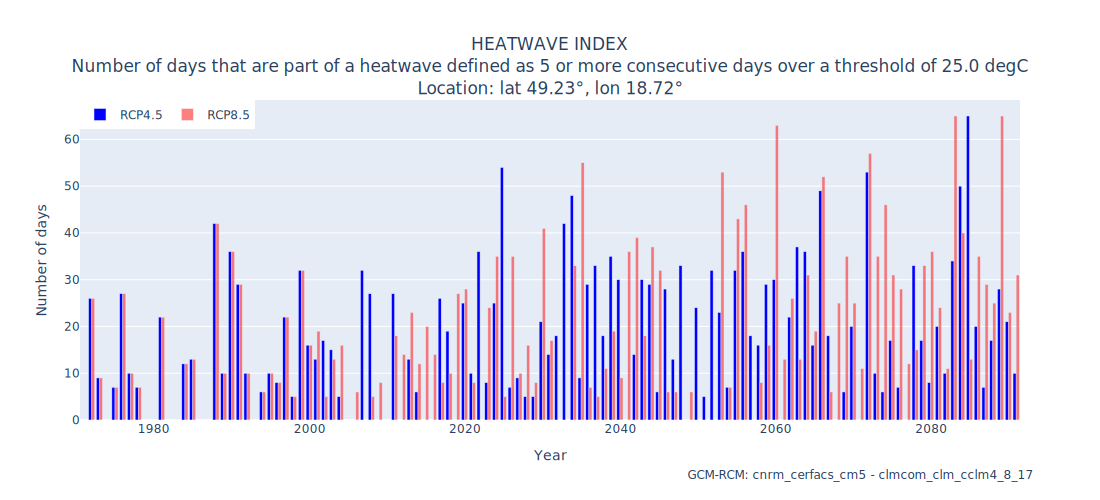

In [21]:
# This code plots the data with heatwave index for the selected pixel 
# Sample data
b = pixel_values_hwih + pixel_values_hwi45
t = pixel_values_hwih + pixel_values_hwi85 
# Define years
yearh = list(range(1971, 2005))
yearp1 = list(range(2006, 2101))
year = yearh + yearp1
# Create figure
fig = go.Figure()
# Add bar trace for 'b'
fig.add_trace(go.Bar(x=year, y=b, name='RCP4.5', marker_color='blue'))
# Add bar trace for 't'
fig.add_trace(go.Bar(x=year, y=t, name='RCP8.5', opacity=0.5, marker_color='red'))

# Add information on models
fig.add_annotation(xref='paper',yref='paper', y=-0.2,x=1, showarrow=False,
            text=f'GCM-RCM: {gcm_model} - {rcm_model}')

# Update layout
fig.update_layout(
    title={
        'text': (
            f'HEATWAVE INDEX<br>Number of days that are part of a heatwave '
            f'defined as {index_settings["window"]} or more consecutive days '
            f'over a threshold of {index_settings["thresh"]}<br>'
            f'Location: lat {lat:.02f}°, lon {lon:.02f}°'
        ),
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='Year',
    yaxis_title='Number of days',
    legend={'x': 0, 'y': 1, 'traceorder': 'normal', 'orientation': 'h'},
    width=1100,
    height=500)

### Plot the heatwave frequency
Number of heatwaves over a given period. A heatwave is defined as an event where the minimum and maximum daily temperature both exceed specific thresholds over a minimum number of days. The number of the heatwaves depends strictly on the threshold which we selected above.

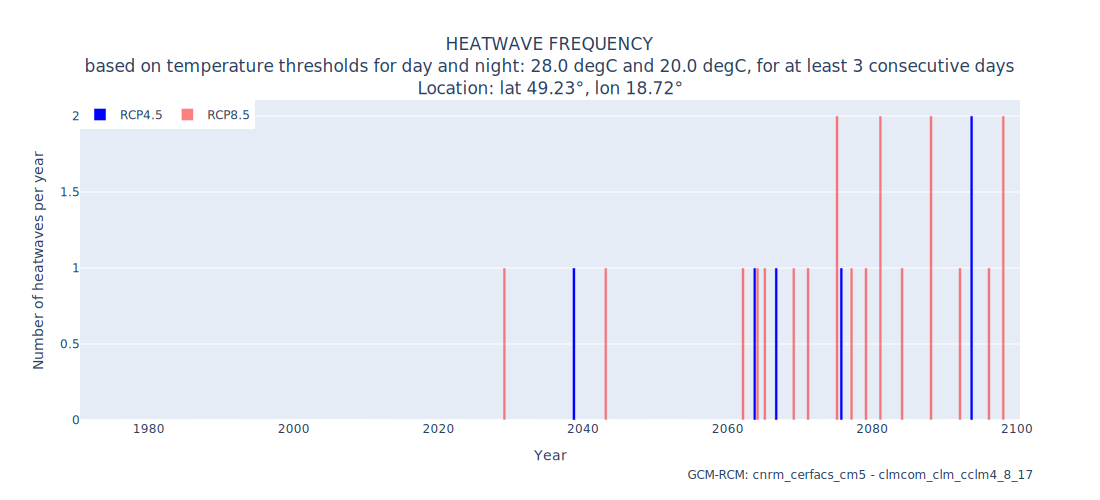

In [22]:
# This code plots the data with heatwave frequency for the selected pixel 
# Sample data
b = pixel_values_hwfh + pixel_values_hwf45
t = pixel_values_hwfh + pixel_values_hwf85 
# Define years
yearh = list(range(1971, 2001))
yearp1 = list(range(2011, 2101))
year = yearh + yearp1
# Create figure
fig = go.Figure()
# Add bar trace for 'b'
fig.add_trace(go.Bar(x=year, y=b, name='RCP4.5', marker_color='blue'))
# Add bar trace for 't'
fig.add_trace(go.Bar(x=year, y=t, name='RCP8.5', opacity=0.5, marker_color='red'))
# Update layout

# Add information on models
fig.add_annotation(xref='paper',yref='paper', y=-0.2,x=1, showarrow=False,
            text=f'GCM-RCM: {gcm_model} - {rcm_model}')

fig.update_layout(
    title={
        'text': (
            f'HEATWAVE FREQUENCY<br>based on temperature thresholds for day and night: '
            f'{frequency_settings["thresh_tasmax"]} and {frequency_settings["thresh_tasmin"]}, '
            f'for at least {frequency_settings["window"]} consecutive days<br>'
            f'Location: lat {lat:.02f}°, lon {lon:.02f}°'
        ),
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='Year',
    yaxis_title='Number of heatwaves per year',
    legend={'x': 0, 'y': 1, 'traceorder': 'normal', 'orientation': 'h'},
    width=1100,
    height=500
)

### Plot the heatwave total length
Total length of heatwaves over a given period. A heatwave is defined as an event where the minimum and maximum daily temperature both exceeds specific thresholds over a minimum number of days. This the sum of all days in such events.

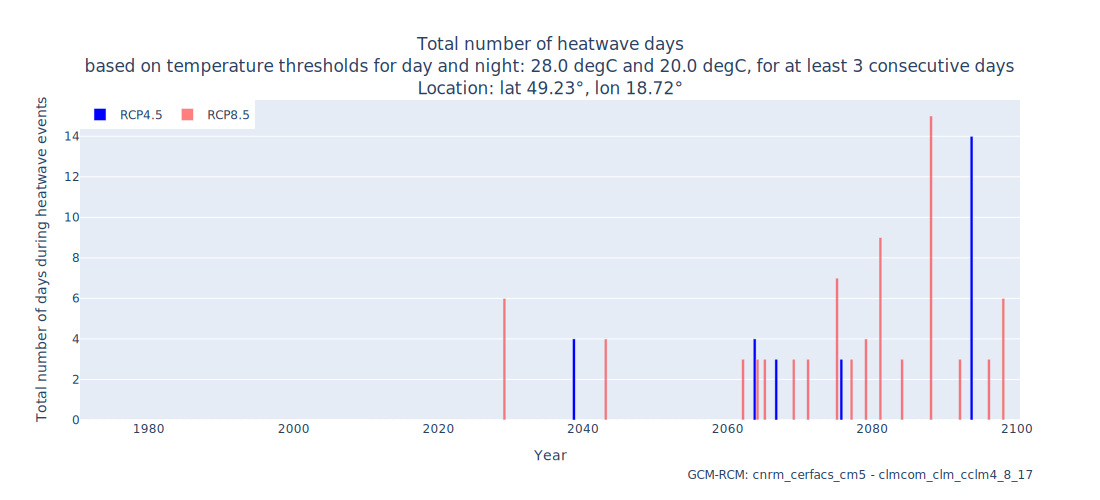

In [23]:
# This code plots the data with heatwave total length for the selected pixel 
# Sample data
b = pixel_values_hwtlh + pixel_values_hwtl45
t = pixel_values_hwtlh + pixel_values_hwtl85 
# Define years
yearh = list(range(1971, 2001))
yearp1 = list(range(2011, 2101))
year = yearh + yearp1
# Create figure
fig = go.Figure()
# Add bar trace for 'b'
fig.add_trace(go.Bar(x=year, y=b, name='RCP4.5', marker_color='blue'))
# Add bar trace for 't'
fig.add_trace(go.Bar(x=year, y=t, name='RCP8.5', opacity=0.5, marker_color='red'))

# Add information on models
fig.add_annotation(xref='paper',yref='paper', y=-0.2,x=1, showarrow=False,
            text=f'GCM-RCM: {gcm_model} - {rcm_model}')

fig.update_layout(
    title={
        'text': (
            f'Total number of heatwave days<br>based on temperature thresholds for day and night: '
            f'{total_length_settings["thresh_tasmax"]} and {total_length_settings["thresh_tasmin"]}, '
            f'for at least {total_length_settings["window"]} consecutive days<br>'
            f'Location: lat {lat:.02f}°, lon {lon:.02f}°'
        ),
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='Year',
    yaxis_title='Total number of days during heatwave events',
    legend={'x': 0, 'y': 1, 'traceorder': 'normal', 'orientation': 'h'},
    width=1100,
    height=500
)

## Conclusions for the XCLIM results 
We calculated three climate indices connected to extreme temperature: heatwave index, heatwave frequency, and heatwave total length for two climate scenarios (RCP4.5 and RCP8.5) based on the EURO-CORDEX data. 

To interpret the plotted results, it is important to remember that the result is dependent on the GCM-RCM combination of climate models that is used in the analysis. This workflow is based on a single model combination, and using a different combination will lead to a different distribution of temperature for specific years. However, the general trend over the entire analysis period will be similar. It is recommended to perform this analysis for several GCM-RCM combinations to check how much the result is dependent on the selection of the models.

The plotted data with indicator values per year should not be used as a forecast of heatwaves for specific years, as this is strongly dependent on the model realization. For policy and planning it may be useful to calculate average indices (e.g. average heatwave occurence) over periods of 20-30 years and compare to historical periods of the same length (e.g. 2040-2060 vs. 1990-2010).

The plotted results are obtained for a single location within the EURO-CORDEX dataset, which corresponds to a 12x12 km cell. The data within this cell does not take into account the finer resolution effects such as the urban heat island effect, and does not take into account future land use changes.

## References

- Copernicus Climate Data Store, [heatwave days for European countries derived from climate projections](https://cds.climate.copernicus.eu/cdsapp#!/software/app-health-heatwaves-projections?tab=app) (2021) [2024-06-17]. 
- Copernicus Climate Data Store, [heatwave days for Europe derived from ERA5 reanalysis](https://cds.climate.copernicus.eu/cdsapp#!/software/app-health-heatwaves-current-climate?tab=app) (2021) [2024-06-17].
- Copernicus Climate Data Store, [heatwave days and heat-related mortality for nine European cities](https://cds.climate.copernicus.eu/cdsapp#!/software/app-health-urban-heat-related-mortality-projections?tab=app) (2021) [2024-06-17].
- Copernicus Climate Data Store, [heatwaves and cold spells in Europe derived from climate projections](https://cds.climate.copernicus.eu/datasets/sis-heat-and-cold-spells?tab=overview) (2019) [2024-06-17].
- Climate adapt, [Apparent temperature heatwave days](https://climate-adapt.eea.europa.eu/en/metadata/indicators/apparent-temperature-heatwave-days) (2021) [2024-06-17].
- Hooyberghs, H., Berckmans, J., Lefebre, F., De Ridder, K. (2019): heatwaves and cold spells in Europe derived from climate projections. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: [10.24381/cds.9e7ca677](https://doi.org/10.24381/cds.9e7ca677).
- Climate adapt, [Tropical nights](https://climate-adapt.eea.europa.eu/en/metadata/indicators/tropical-nights) (2021) [2025-07-14].
- Climate adapt, [High UTCI Days](https://climate-adapt.eea.europa.eu/en/metadata/indicators/high-utci-days) (2021) [2024-06-17].
- Bourgault et al., (2023). Xclim: xarray-based climate data analytics. Journal of Open Source Software, 8(85), 5415, DOI: [10.21105/joss.05415](https://doi.org/10.21105/joss.05415)

## Authors

- Martin Kuban, KAJO services (martin.kuban@kajoservices.com)
- Milan Kalas, KAJO services (milan.kalas@kajoservices.com)
- Milica Aleksic, KAJO services (milica.aleksic@kajoservices.com)
- Natalia Aleksandrova, Deltares (review and editing)